In [1]:
import numpy as np
import pandas as pd
from pandarallel import pandarallel
import random

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

from mxfp import MXFPCalculator
import tmap as tm
from faerun import Faerun

pandarallel.initialize(progress_bar=True)
random.seed(42)


INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
df = pd.read_csv('ChEMBL_short24.1.mxfp', header=None, sep='\s+|;', engine='python')
df[226] = df.iloc[:, 2:225].values.tolist()
df = df[df.columns[[0, 1, 226]]]
df.columns = ['SMILES', 'Name', 'MXFP_java']

df = df.head(1000)

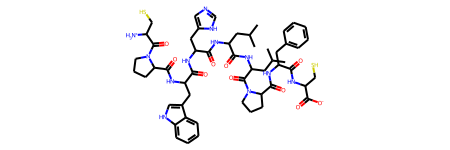

In [3]:
MXFP = MXFPCalculator()

testsmiles = df['SMILES'].iloc[11]
testmol = Chem.MolFromSmiles(testsmiles)

testmol

In [4]:
testpython = []

test_mxfp_python = MXFP.calc_mxfp(testmol)
testpython.append(test_mxfp_python)
testpython = [i for sublist in testpython for i in sublist]
testpython = np.array(testpython)

testjava = df['MXFP_java'].iloc[11]
testjava = np.array(testjava)

testpython_pd = pd.DataFrame(testpython)
testjava_pd = pd.DataFrame(testjava)

testlist = pd.concat([testpython_pd, testjava_pd], ignore_index=True, axis=1, join='inner')
testlist.to_csv('testlist.csv', sep='\t', index=None, header=None)

In [ ]:
#df = df.drop(df[df.SMILES.str.contains(r'[%]')].index)

#mollist = []

#for mol in df.SMILES:
    #moltype = Chem.MolFromSmiles(mol)
    #if moltype == None: continue
    #elif moltype != None:
        #mollist.append([mol, moltype])

#datalist = pd.DataFrame(mollist, columns=['SMILES', 'mol'])

#print(f'Number of molecules: {len(mollist)}')

In [ ]:
MXFP = MXFPCalculator()

def calc_mxfp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mxfp = MXFP.get_mxfp(mol)
    return np.array(mxfp)

In [ ]:
df["MXFP_python"] = df.SMILES.parallel_map(calc_mxfp)
mxfp_python = df.MXFP_python.tolist()

In [ ]:
mweight = [] 

for smiles in df['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    weigh = rdMolDescriptors.CalcExactMolWt(mol)
    mweight.append(weigh)


In [ ]:
lf = tm.LSHForest(1024, 64)

mxfp_java_list = df.MXFP_java.to_list()
mxfp_java = []

for i in range(len(mxfp_java_list)):
    x = np.asarray(mxfp_java_list[i])
    mxfp_java.append(x)

In [ ]:
fps = []

for i in mxfp_java:
    vec = tm.VectorUint(i)
    fps.append(vec)


In [ ]:
lf.batch_add(fps)
lf.index()

In [ ]:
cfg = tm.LayoutConfiguration()
cfg.node_size = 1 / 35
cfg.mmm_repeats = 2
cfg.sl_extra_scaling_steps = 10
cfg.k = 20
cfg.sl_scaling_type = tm.RelativeToAvgLength
x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)

In [ ]:
f = Faerun(view="front", coords=False)
f.add_scatter(
    "mxfp",
    {
        "x": x,
        "y": y,
        "c": [mweight],
            "labels": df["SMILES"],
    },
    shader="smoothCircle",
    point_scale=2.0,
    max_point_size=20,
    legend_labels=[],
    categorical=[False],
    colormap=['rainbow'],
    series_title=['MW'],
    has_legend=True,
)
f.add_tree("mxfp_tree", {"from": s, "to": t}, point_helper="mxfp")
f.plot(template="smiles")